In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from scipy.io import loadmat
import pandas as pd

In [2]:
data = loadmat("data.mat")
print(data['Reduced_Data'])
df = pd.DataFrame(data['Reduced_Data'])

[[array([[ 0, 10, -5]], dtype=int16)
  array([[ 0.00000000e+00,  3.68594486e+01,  4.56162328e+01,
           5.18765022e+01,  5.68948351e+01,  6.10980503e+01,
           6.46844073e+01,  6.77681369e+01,  7.04269794e+01,
           7.27205689e+01,  7.46974415e+01,  7.63982357e+01,
           7.78577248e+01,  7.91057029e+01,  8.01683841e+01,
           8.10689093e+01,  8.18273920e+01,  8.24614306e+01,
           8.29863960e+01,  8.34161926e+01,  8.37627735e+01,
           8.40374323e+01,  8.42495985e+01,  8.44075370e+01,
           8.45185075e+01,  8.45895075e+01,  8.46260008e+01,
           8.46331979e+01,  8.46155264e+01,  8.45768989e+01,
           8.45207989e+01,  8.44502400e+01,  8.43678817e+01,
           8.42760487e+01,  8.41768276e+01,  8.40718914e+01,
           8.39626993e+01,  8.38506719e+01,  8.37366776e+01,
           8.36219159e+01,  8.35070235e+01,  8.33926799e+01,
           8.32795779e+01,  8.31680648e+01,  8.30586769e+01,
           8.29516494e+01,  8.28472592e+01,  8.2

In [3]:
def create_model(n_states=12, n_BCs=3, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(n_BCs), name="BCs")
    branch = tf.keras.layers.Dense(128, activation="tanh")(branch_input)
    for i in range(2):
        branch = tf.keras.layers.Dense(64, activation="tanh")(branch)
    
    # Trunk net
    trunk_input = tf.keras.Input(shape=(n_states), name="time")
    trunk = tf.keras.layers.Dense(128, activation="tanh")(trunk_input)   
    for i in range(2):
        trunk = tf.keras.layers.Dense(64, activation="tanh")(trunk)
    
    # Compute the dot product between branch and trunk net
    dot_product = tf.multiply(branch, trunk)
    
    # Add the bias
    output = tf.keras.layers.Dense(n_states)(dot_product)
    
    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)
    
    if verbose:
        model.summary()
        
    return model   

In [4]:
n_states = 8
deepOnet = create_model(n_states=n_states, verbose=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 BCs (InputLayer)            [(None, 3)]                  0         []                            
                                                                                                  
 time (InputLayer)           [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  512       ['BCs[0][0]']                 
                                                                                                  
 dense_3 (Dense)             (None, 128)                  1152      ['time[0][0]']                
                                                                                             

In [5]:
# Wrangling the data
X_Branch = []
X_Trunk = []
for i in range(np.shape(df[0])[0]): # the number of simulations in the data set
    for j in range(np.shape(df[1][0])[1]): # the second index of the shape of the time series data
        X_Branch.append(np.array(df[0][i]))
        X_Trunk.append(np.array(df[1][i][:,j]))

X_Branch = np.array(X_Branch).reshape(np.shape(df[0])[0]*np.shape(df[1][0])[1],np.shape(df[0][0])[1])
X_Trunk = np.array(X_Trunk)

y = []
for k in range(np.shape(df[0])[0]):
    for l in range(np.shape(df[2][0])[1]): # the second index of the shape of the time series data
        y.append(np.array(df[2][k][:,l]))

y = np.array(y)

In [6]:
learn_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
deepOnet.compile(optimizer=optimizer,
                loss='mse',
                metrics=[keras.metrics.MeanSquaredError()])

In [7]:
fit = deepOnet.fit([X_Branch, X_Trunk], y, epochs=200)

Epoch 1/200

94/94 [==============================] - 2s 2ms/step - loss: 58.7949 - mean_squared_error: 58.7949
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 27.3614 - mean_squared_error: 27.3614
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 14.3156 - mean_squared_error: 14.3156
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 7.7060 - mean_squared_error: 7.7060
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 4.2709 - mean_squared_error: 4.2709
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 2.3789 - mean_squared_error: 2.3789
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - loss: 1.3873 - mean_squared_error: 1.3873
Epoch 8/200
94/94 [==============================] - 0s 2ms/step - loss: 0.8756 - mean_squared_error: 0.8756
Epoch 9/200
94/94 [==============================] - 0s 2ms/step - loss: 0.5820 - mean_squared_error: 0.5820
Epoch 10/200

In [8]:
y_pred = deepOnet.predict([X_Branch, X_Trunk])


94/94 [==============================] - 0s 1ms/step


In [9]:
deepOnet.save(filepath="C:/Users/MorgadoBruno/Documents/ML_ROM_PROJECT_24/code/model", save_format='tf')

INFO:tensorflow:Assets written to: C:/Users/MorgadoBruno/Documents/ML_ROM_PROJECT_24/code/model\assets


INFO:tensorflow:Assets written to: C:/Users/MorgadoBruno/Documents/ML_ROM_PROJECT_24/code/model\assets


# Simulating ODE

In [10]:
FEM_r = loadmat("R_FE_Mats.mat")
FEM_r = FEM_r["Reduced_FE_Matrices"]

Kr = FEM_r[0][0][1]
Lr = FEM_r[0][0][2]
M_inv = FEM_r[0][0][3]


In [11]:
from scipy.integrate import solve_ivp

class source_vec():
    def __init__(self, model):
        self.model = model

    def predict_F(self, BCs, u):
        return self.model.predict([BCs, np.expand_dims(u, axis=0)])[0]

source = source_vec(deepOnet)

def dydt_func(t, u, M_inv, Kr, BCs, nn_object):
    F = nn_object.predict_F(BCs, u)
    dydt = M_inv@(F - Kr@u)

    return dydt

In [12]:
u0 = np.zeros([n_states,])
tlist = np.linspace(0,2,500)
BCs = np.expand_dims([100,-10,20], axis=0)
u = solve_ivp(fun=dydt_func, y0=u0, t_span=(0,2),t_eval=tlist, args=(M_inv, Kr, BCs, source), method="BDF")

1/1 [==============================] - 0s 30ms/step


In [13]:
print(u)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.008e-03 ...  1.996e+00  2.000e+00]
        y: [[ 0.000e+00 -9.891e+01 ... -5.259e+02 -5.259e+02]
            [ 0.000e+00  4.778e+01 ... -1.751e+02 -1.751e+02]
            ...
            [ 0.000e+00  1.413e+01 ...  5.457e+00  5.456e+00]
            [ 0.000e+00 -7.061e+01 ... -1.288e+00 -1.288e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 387
     njev: 12
      nlu: 49


In [14]:
temp_sensors_NN = Lr@np.array(u['y'])

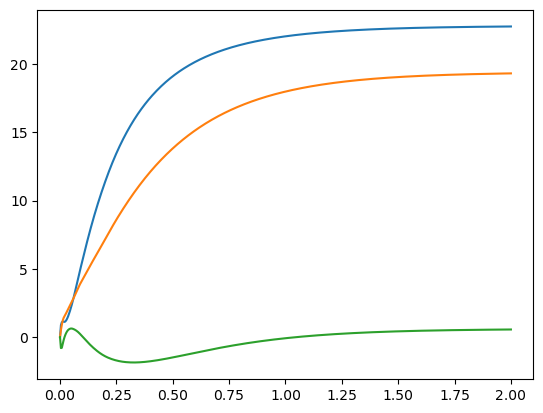

In [15]:
plt.plot(tlist,temp_sensors_NN[0])
plt.plot(tlist,temp_sensors_NN[1])
plt.plot(tlist,temp_sensors_NN[2])

Appendix

In [16]:
print(y_pred[1100])
print(y[1100])

[-2.4747349e+01 -5.0151205e+00  3.3516865e+01  1.5886313e+01
 -4.0909320e-01 -1.1641659e-02 -5.4989263e-02  4.4863857e-03]
[-2.47500673e+01 -5.01074842e+00  3.35304900e+01  1.58843782e+01
 -3.85096275e-01 -1.22074107e-02 -6.95412485e-02  2.71570904e-03]


In [17]:
print(np.array(df[2][1][:,0]))

[-1.23743789e+00 -2.50446974e-01  1.67655463e+00  7.94274289e-01
 -1.91000018e-02 -6.18781884e-04 -3.50660203e-03  1.38310510e-04]


In [18]:
np.shape(df[1][0])[1]


100

In [19]:
np.shape(df[0][0])

(1, 3)

In [20]:
df[2][0][:,0]

array([ 6.10126255e+00, -1.23962378e+01,  5.60060119e+00,  9.61548819e+00,
       -7.04360281e-02,  2.69017257e-02, -1.49826672e-02, -2.71959813e-04])

In [21]:
x = deepOnet.predict([np.expand_dims(X_Branch[0], axis=0), np.expand_dims(X_Trunk[0], axis=0)])
print(deepOnet.predict([np.expand_dims(X_Branch[0], axis=0), np.expand_dims(X_Trunk[0], axis=0)]))
print(x[0])
# print(np.shape(np.newaxis(X_Branch[0])))
# np.expand_dims(X_Branch[0], axis=0)

1/1 [==============================] - 0s 30ms/step
[[ 5.92625332e+00 -1.23926334e+01  5.75991344e+00  9.69448566e+00
  -1.09046474e-01  4.63213474e-02  1.04703810e-02  1.09676756e-02]]
[ 5.92625332e+00 -1.23926334e+01  5.75991344e+00  9.69448566e+00
 -1.09046474e-01  4.63213474e-02  1.04703810e-02  1.09676756e-02]


In [22]:
print(X_Branch[500])

[ 0 20 20]
